# 2D heat transfer on a plate using pytorch

$$\frac{\partial T}{\partial t} = \alpha ( \frac{\partial ^2 T}{\partial^2 x} + \frac{\partial ^2 T}{\partial^2 y})+ \frac{Q}{\rho C_p}$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns

In [2]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# defining the network
class PINN(nn.Module):
    def __init__(self):
        super(PINN , self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3 , 64),
            nn.Tanh(),
            nn.Linear(64 , 64),
            nn.Tanh(),
            nn.Linear(64 , 64),
            nn.Tanh(),
            nn.Linear(64 , 1)
            )

    def forward(self , x):
        return self.net(x)

In [4]:
# IC & DC
def initial_condition(x,y):
    init= torch.zeros_like(x)
    return init

def boundary_condition(x , y , t , costume_value):
    return torch.full_like(x , costume_value)

In [5]:
# generating the computational domain
def generate_training_data(num_points):
    x= torch.rand(num_points , 1 , requires_grad=True)
    y= torch.rand(num_points , 1 , requires_grad=True)
    t= torch.rand(num_points , 1 , requires_grad=True)
    return x,y,t

def generate_boundary_points(num_points):
    # Divide points approximately equally among four boundaries
    points_per_boundary = num_points // 4
    extra_points = num_points % 4
    # Vertical(x = 0 and x = 1)
    x_v = torch.tensor([0.0] * points_per_boundary + [1.0] * points_per_boundary)
    y_v = torch.rand(2 * points_per_boundary)
    # Horizontal(y = 0 and y = 1)
    x_h = torch.rand(2 * points_per_boundary)
    y_h = torch.tensor([0.0] * points_per_boundary + [1.0] * points_per_boundary)
    x_boundary = torch.cat([x_v, x_h])
    y_boundary = torch.cat([y_v, y_h])
    # Handle extra points if num_points is not divisible by 4
    if extra_points > 0:
        x_extra = torch.tensor([0.0, 1.0, torch.rand(1)[0], torch.rand(1)[0]])
        y_extra = torch.rand(extra_points)
        x_boundary = torch.cat([x_boundary, x_extra[:extra_points]])
        y_boundary = torch.cat([y_boundary, y_extra])

    return x_boundary.view(-1, 1), y_boundary.view(-1, 1)

def generate_boundary_training_data(num_points):
    x_boundary , y_boundary = generate_boundary_points(num_points)
    t = torch.rand(num_points , 1 , requires_grad=True)
    return x_boundary , y_boundary , t

In [6]:
# loss
def pde(x,y,t,model):
    Q , rho , cp=5,1,1
    input_data = torch.cat([x,y,t] , dim=1)
    u = model(input_data)
    u_x , u_y  = torch.autograd.grad(u ,[x , y] , grad_outputs = torch.ones_like(u) , create_graph = True , retain_graph=True)
    u_xx= torch.autograd.grad(u_x ,x , grad_outputs = torch.ones_like(u_x) , create_graph = True , retain_graph=True)[0]
    u_yy= torch.autograd.grad(u_y ,y , grad_outputs = torch.ones_like(u_y) , create_graph = True , retain_graph=True)[0]
    u_t = torch.autograd.grad(u ,t, grad_outputs = torch.ones_like(u) , create_graph = True , retain_graph=True)[0]

    return 0.1 * (u_xx+u_yy) + (Q/(rho*cp))  - u_t

In [7]:
# setting the optimizer
def train_PINN(model , num_iteration , num_points):
    optimizer =  optim.Adam(model.parameters() , lr= 1e-3)

    model.to(device)

    for iteration in range(num_iteration+1):
        optimizer.zero_grad()
        x,y,t = generate_training_data(num_points)
        x,y,t = x.to(device) , y.to(device) , t.to(device)
        x_b , y_b , t_b = generate_boundary_training_data(num_points)
        x_b,y_b,t_b = x_b.to(device) , y_b.to(device) , t_b.to(device)
        t_initial = torch.zeros_like(t).to(device)
        u_initial = initial_condition(x,y).to(device)

        costume_value = 0
        u_boundary = boundary_condition(x_b , y_b , t_b , costume_value=0)

        # Move boundary condition values to GPU
        u_boundary = u_boundary.to(device)

        residual= pde(x, y, t ,model)

        # Calculate individual loss terms
        ic_loss = nn.MSELoss()(u_initial , model(torch.cat([x,y,t_initial] , dim=1)))
        bc_loss = nn.MSELoss()(u_boundary  , model(torch.cat([x_b,y_b,t_b] , dim=1)))
        pde_loss = nn.MSELoss()(residual , torch.zeros_like(residual).to(device))

        loss = ic_loss + bc_loss + pde_loss


        loss.backward()
        optimizer.step()

        if iteration % 1000 == 0:
            print(f"ITERATION: {iteration:>5} |   TOTAL LOSS: {loss.item():.4f} |   IC LOSS: {ic_loss.item():.4f} |   BC LOSS: {bc_loss.item():.4f} |   PDE LOSS: {pde_loss.item():.4f}")

In [8]:
# training the model
model = PINN()
num_iteration = 10000
num_points = 1500

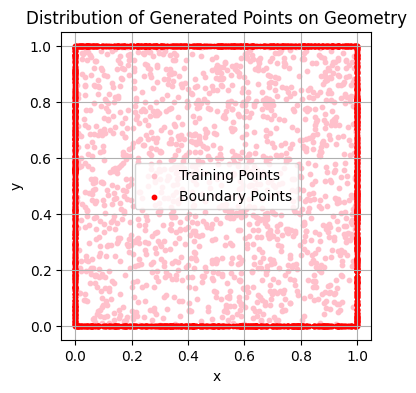

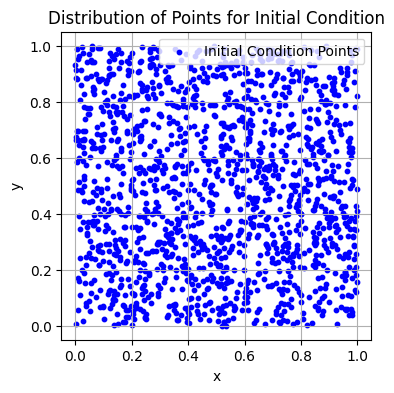

In [9]:
# Plotting the generated points before training
# Generate points for visualization
x, y, t = generate_training_data(num_points)
x_b, y_b, t_b = generate_boundary_training_data(num_points)
t_initial = torch.zeros_like(t)
x_initial, y_initial, _ = generate_training_data(num_points)

# Plot 1: Geometry with training  boundary points
plt.figure(figsize=(4, 4))
plt.scatter(x.detach().numpy(), y.detach().numpy(), color='pink', label='Training Points', s=10)
plt.scatter(x_b.detach().numpy(), y_b.detach().numpy(), color='red', label='Boundary Points', s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distribution of Generated Points on Geometry")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Points used for initial condition
plt.figure(figsize=(4, 4))
plt.scatter(x_initial.detach().numpy(), y_initial.detach().numpy(), color='blue', label='Initial Condition Points', s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distribution of Points for Initial Condition")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
train_PINN(model , num_iteration , num_points)

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


ITERATION:     0 |   TOTAL LOSS: 25.3338 |   IC LOSS: 0.0246 |   BC LOSS: 0.0294 |   PDE LOSS: 25.2798
ITERATION:  1000 |   TOTAL LOSS: 0.1163 |   IC LOSS: 0.0089 |   BC LOSS: 0.0804 |   PDE LOSS: 0.0269
ITERATION:  2000 |   TOTAL LOSS: 0.0438 |   IC LOSS: 0.0084 |   BC LOSS: 0.0222 |   PDE LOSS: 0.0132
ITERATION:  3000 |   TOTAL LOSS: 0.0285 |   IC LOSS: 0.0082 |   BC LOSS: 0.0133 |   PDE LOSS: 0.0071
ITERATION:  4000 |   TOTAL LOSS: 0.0200 |   IC LOSS: 0.0060 |   BC LOSS: 0.0090 |   PDE LOSS: 0.0051
ITERATION:  5000 |   TOTAL LOSS: 0.0185 |   IC LOSS: 0.0064 |   BC LOSS: 0.0086 |   PDE LOSS: 0.0035
ITERATION:  6000 |   TOTAL LOSS: 0.0129 |   IC LOSS: 0.0044 |   BC LOSS: 0.0060 |   PDE LOSS: 0.0025
ITERATION:  7000 |   TOTAL LOSS: 0.0114 |   IC LOSS: 0.0036 |   BC LOSS: 0.0051 |   PDE LOSS: 0.0027
ITERATION:  8000 |   TOTAL LOSS: 0.0094 |   IC LOSS: 0.0026 |   BC LOSS: 0.0047 |   PDE LOSS: 0.0022
ITERATION:  9000 |   TOTAL LOSS: 0.0082 |   IC LOSS: 0.0022 |   BC LOSS: 0.0044 |   PDE L

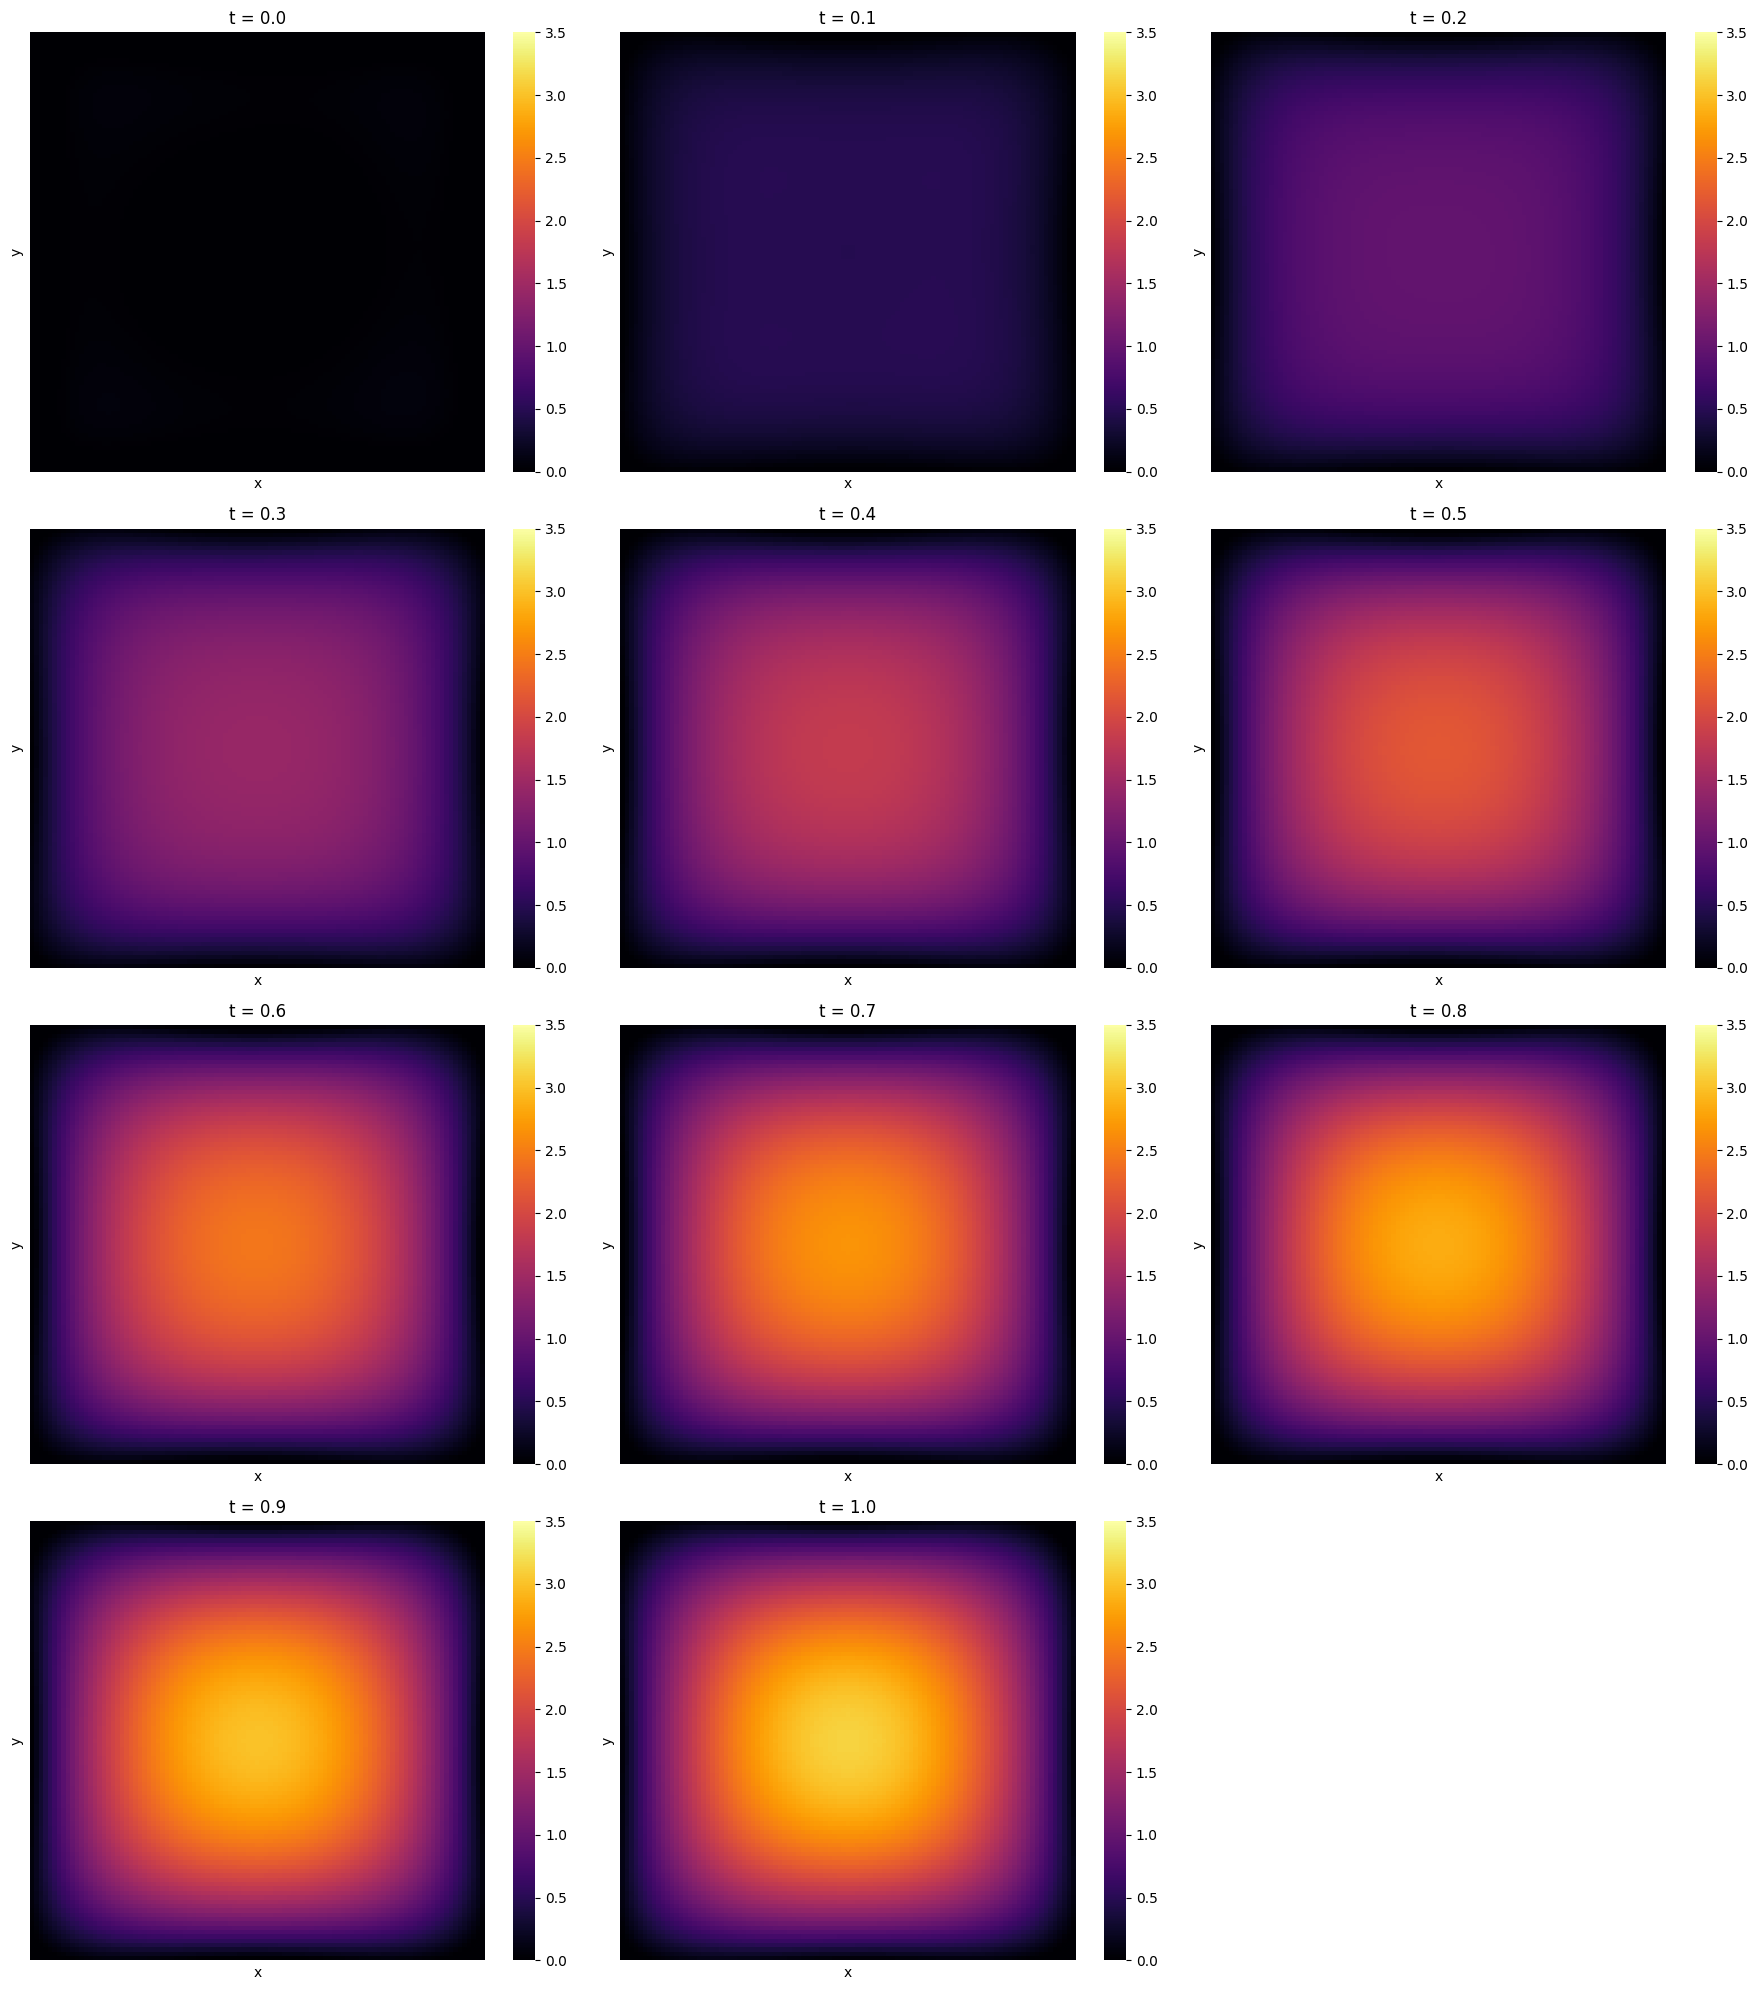

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Spatial resolution for plotting
x_vals = torch.linspace(0, 1, 100+1)
y_vals = torch.linspace(0, 1, 100+1)
X, Y = torch.meshgrid(x_vals, y_vals)

# Time steps to visualize
time_steps_to_plot = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

# Iterate through the time steps and plot the heatmap
for i, t in enumerate(time_steps_to_plot):
    if i < len(axes): # Ensure we don't go out of bounds
        # Create input data for the model for the current time step
        t_val = torch.full_like(X, t)
        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1).to(device)

        # Get model prediction
        with torch.no_grad():
            solution_data = model(input_data).reshape(X.shape , Y.shape).cpu().numpy()


        # Plot the heatmap
        sns.heatmap(solution_data, cmap="inferno", vmin=0, vmax=3.5, ax=axes[i], cbar=True) # Set cbar to True
        axes[i].set_title(f"t = {t:.1f}")
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("y")
        axes[i].invert_yaxis() # Invert y-axis to match spatial orientation
        axes[i].set_xticks([]) # Remove x-axis ticks
        axes[i].set_yticks([]) # Remove y-axis ticks


# Hide any unused subplots
for j in range(len(time_steps_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

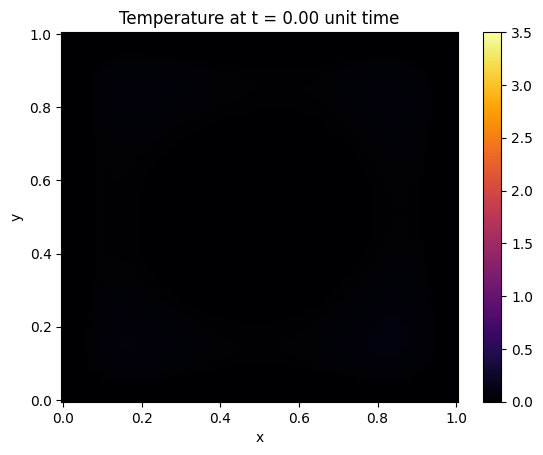

In [14]:
# Parameters
nelx = 100
nely = 100
timesteps = 101
x = np.linspace(0, 1, nelx+1)
y = np.linspace(0, 1, nely+1)
t = np.linspace(0, 1, timesteps)
delta_t = t[1] - t[0]
xx, yy = np.meshgrid(x, y)

# Prepare for animation
fig = plt.figure()
ax = fig.add_subplot(111)
Ts = []

# Evaluate model at each timestep
for time in t:
    with torch.no_grad():
        x_vals = torch.linspace(0, 1, nelx+1).to(device) # Move to device
        y_vals = torch.linspace(0, 1, nely+1).to(device) # Move to device
        X, Y = torch.meshgrid(x_vals, y_vals)
        t_val = torch.ones_like(X) * time

        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
        solution = model(input_data).reshape(X.shape, Y.shape).cpu() # Move back to CPU

        # Convert to numpy and scale if needed
        T = solution.numpy() # Scaling factor as in your first code
        Ts.append(T)

# Animation function
def plotheatmap(T, time):
    plt.clf()
    plt.title(f"Temperature at t = {time*delta_t:.2f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.pcolormesh(xx, yy, T, cmap='inferno', vmin=0, vmax=3.5)  # Using turbo colormap as in second code
    plt.colorbar()
    return plt

def animate(k):
    plotheatmap(Ts[k], k)

# Create and save animation
anim = animation.FuncAnimation(fig, animate, interval=50, frames=len(t), repeat=False)
anim.save("heat_generation.gif", writer='pillow', fps=10)

In [15]:
import pandas as pd

# Generate evaluation points
x_vals = np.linspace(0, 1, 10+1)
y_vals = np.linspace(0, 1, 10+1)
t_vals = np.linspace(0, 1, 10+1) # timesteps from 0 to 1

# Create a base DataFrame with X and Y coordinates
X, Y = np.meshgrid(x_vals, y_vals)
df = pd.DataFrame({
    'X': X.ravel(),
    'Y': Y.ravel()
})

# Sort by X then Y
df = df.sort_values(by=['X', 'Y']).reset_index(drop=True)

# Add columns for each timestep and populate with model predictions
for t in t_vals:
    # Create grid for current time step
    points = np.vstack([X.ravel(), Y.ravel(), np.full_like(X.ravel(), t)]).T

    # Convert to torch tensors and move to device
    x_torch = torch.FloatTensor(points[:, 0]).unsqueeze(1).to(device) # Move to device
    y_torch = torch.FloatTensor(points[:, 1]).unsqueeze(1).to(device) # Move to device
    t_torch = torch.FloatTensor(points[:, 2]).unsqueeze(1).to(device) # Move to device

    # Model prediction
    with torch.no_grad():
        input_data = torch.cat([x_torch, y_torch, t_torch], dim=1)
        model_pred = model(input_data).cpu().numpy().flatten() # Move back to CPU for numpy

    # Add model predictions to the DataFrame for the current timestep, formatted to 3 decimal places
    df[f't={t:.1f}'] = [f"{val:.3f}" for val in model_pred[df.index]] # Assign based on sorted index and format

# Save to CSV
df.to_csv('heat_generation.csv', index=False)
print("CSV file saved with time-sorted data!")

CSV file saved with time-sorted data!
